# Final Project Report

* Class: DS 5100
* Student Name: Lucy Shichman
* Student Net ID: lgs4zj
* This URL: a URL to the notebook source of this document

# Instructions

Follow the instructions in the Final Project isntructions notebook and put evidence of your work in this notebook.

Total points for each subsection under **Deliverables** and **Scenarios** are given in parentheses.

Breakdowns of points within subsections are specified within subsection instructions as bulleted lists.

This project is worth **50 points**.

# Deliverables

## The Monte Carlo Module (10)

- URL included, appropriately named (1).
- Includes all three specified classes (3).
- Includes at least all 12 specified methods (6; .5 each).

Put the URL to your GitHub repo here.

Repo URL: https://github.com/Lucy-Shichman/DS5100-finalproject-lgs4zj

Paste a copyy of your module here.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

```python
import numpy as np
import pandas as pd

class Die():
    """
    This class creates a Die object, changes it's weight, 
    rolls it, and returns it's current state.
    """
    def __init__(self, faces):
        """
        Initializes faces and weight attributes of die object.
        
        Takes a "faces" input argument that must be a NumPy array
        of distinct values (array's data type may by a string, integer, 
        or float).
        
        Internally initializes the weights to 1.0 for each face. 
        """  
        if type(faces) != np.ndarray:
            raise TypeError("Faces input must be a NumPy array")
        
        if len(faces) != len(np.unique(faces)):
            raise ValueError("Array values must be distinct")
        
        self.faces = faces
        self.weights = [1 for i in faces]
        self.__die = pd.DataFrame({
            "weights" : self.weights
        }).set_index(self.faces)
    
    def change_weight(self, face_value, new_weight):
        """
        Changes the weight of a single face of the die object.
        
        Takes two input arguments: the face value (string or numeric) 
        to be changed and the new weight (integer or float)
        """
        if face_value not in self.faces:
            raise IndexError("face_value input is not a valid value")
        
        try:
            float(new_weight)
        except:
            raise TypeError("new_weight input is not a valid type")
        
        self.__die.loc[face_value] = new_weight
    
    def roll_die(self, num_rolls = 1):
        """
        Rolls the die object one or more times.
        
        Takes one input argument, num_rolls (integer), which specifies
        the number of times the die object is rolled. Defaults to 1.
        
        Returns a list of subsequent outcomes.
        """
        outcomes = []
        for i in range(num_rolls):
            outcome = self.__die.sample(weights = self.__die.weights).index[0]
            outcomes.append(outcome)
        return outcomes
    
    def current_state(self):
        """
        Shows the die object's current state.
        
        Returns a data frame of the object's faces and weights.
        """
        return self.__die

class Game():
    """
    This class creates a game object. A game consists of rolling one 
    or more similar dice (Die objects) one or more times.
    """
    def __init__(self, die_list):
        """
        Initializes list of die objects.
        
        Takes argument die_list (list of Die class objects) of already
        instantiated similar dice.
        """
        self.die_list = die_list
    
    def play_game(self, game_rolls):
        """
        Rolls all dice a specified number of times.
        
        Takes argument game_rolls (integer) to specify how many times
        the die should be rolled.
        """
        outcomes = []
        for die in self.die_list:
            outcome = die.roll_die(game_rolls)
            outcomes.append(outcome)
            
        self.__outcome_df = pd.DataFrame(outcomes,
                                      columns = ("Roll " + str(i+1) for i in range(0, game_rolls)),
                                      index = ("Die " + str(i+1) for i in range(len(self.die_list)))).T
    
    def game_results(self, form = "wide"):
        """
        Returns game results data frame in a specified format.
        
        Takes argument form ("wide" or "narrow") that specifies the
        format of the returned data frame. Defaults to wide format.
        """
        if form.lower() != "wide" and form.lower() != "narrow":
            raise ValueError("form input must be 'wide' or 'narrow'")
        
        if form.lower() == "wide":
            return self.__outcome_df
        
        if form.lower() == "narrow":
            narrow_df = self.__outcome_df.reset_index().melt(id_vars = "index",
                                                             var_name = "Die Number",
                                                             value_name = "Outcome")
            narrow_df = narrow_df.set_index(['index','Die Number']).sort_index()
            return narrow_df    

class Analyzer():
    """
    This class creates an analyzer object which takes the 
    results of a single game and computes various descriptive
    statistical properties about it.
    """
    def __init__(self, game_object):
        """
        Initializes an Analyzer object.
        
        Takes argument game_object (Game class object), an already instantiated game.
        
        Initializes a game_object attribute to store the Game object
        and an outcomes attribute to store the Game object's results.
        """
        if not isinstance(game_object, Game):
            raise ValueError("game_object input must be a Game object")
        
        self.game_object = game_object
        self.outcomes = game_object.game_results()
        
    def jackpot(self):
        """
        Computes how many times the game resulted in a jackpot
        (a result in which all faces are the same).
        
        Returns the number of jackpots as an integer.
        """
        num_jackpots = self.outcomes.apply(lambda x: len(x.unique()) == 1, axis = 1).sum()
        
        return num_jackpots
    
    def face_counts(self):
        """
        Computes how many times a given face is rolled in each event.
        
        Returns a wide format data frame of the results.
        """
        face_counts_df = self.outcomes.apply(lambda x: x.value_counts(), axis = 1).fillna(0)
        
        face_counts_df.index = ["Roll " + str(i+1) for i in range(0, len(face_counts_df))]
        face_counts_df.columns = face_counts_df.columns.sort_values()
        
        return face_counts_df
    
    def combo_count(self):
        """
        Computes the distinct combinations (order independent) of faces rolled, 
        along with their counts.
        
        Returns a multi-indexed data frame of the distinct combinations and
        their associated counts.
        """
        combo_df = self.outcomes.apply(lambda x: x.sort_values(), axis=1, result_type = "broadcast")
        combo_df = combo_df.groupby([i for i in combo_df.columns]).size().reset_index(name = "count")
        combo_df = combo_df.set_index([i for i in combo_df.columns])#.sort_values(["count"], ascending=False)
        
        return combo_df
        
    def perm_count(self):
        """
        Computes the distinct permutations (order dependent) of faces rolled, 
        along with their counts.
        
        Returns a multi-indexed data frame of the distinct combination and 
        their associated counts.
        """
        perm_df = self.outcomes.groupby([i for i in self.outcomes.columns]).size().reset_index(name = "count")
        perm_df = perm_df.set_index([i for i in self.outcomes.columns])#.sort_values(["count"], ascending=False)
        
        return perm_df
```

## Unitest Module (2)

Paste a copy of your test module below.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

- All methods have at least one test method (1).
- Each method employs one of Unittest's Assert methods (1).

```python
import numpy as np
import pandas as pd

import unittest
from montecarlo.montecarlo import Die, Game, Analyzer

class MonteCarloTestSuite(unittest.TestCase):

    def test_1_Die_init(self):
        '''
        initialize a die with 3 faces. 
        test whether faces is an array with distinct values.
        '''
        faces = np.array(['a','b','c'])
        die1 = Die(faces)
        
        expected = (type(faces) == np.ndarray) & (len(faces) == len(np.unique(faces)))
        self.assertTrue(expected)
   
    def test_2_change_weight(self):
        '''
        change the weight of one face. 
        test if the new weight is in the dataframe.
        '''
        die1 = Die(np.array([1,2,3]))
        die1.change_weight(1,5)
        
        expected = die1.current_state().weights.isin([5]).sum()
        self.assertTrue(expected)
    
    def test_3_roll_die(self):
        '''
        roll the die twice. 
        test if the method returns a list of length 2.
        '''
        die1 = Die(np.array(['x','y','z']))
        
        expected = isinstance(die1.roll_die(2), list) and len(die1.roll_die(2))==2
        self.assertTrue(expected)
    
    def test_4_current_state(self):
        '''
        initialize a die with 6 faces. 
        test if the dataframe returned by current_state() has an index of length 6
        '''
        die1 = Die(np.array(['this','die','has','six','total','faces']))
        
        actual = len(die1.current_state())
        expected = 6
        self.assertEqual(actual, expected)
    
    def test_5_Game_init(self):
        '''
        initialize a Game objects. 
        test if die_list input is a list.
        '''
        die1 = Die(np.array(['1','2','3']))
        die2 = Die(np.array(['1','2','3']))
        game1 = Game([die1, die2])
        
        expected = type(game1.die_list) == list
        self.assertTrue(expected)
    
    def test_6_play_game(self):
        '''
        play a game with 5 rolls.
        test if results are properly stored in a dataframe with an index length of 5
        '''
        die1 = Die(np.array(['1','2','3']))
        die2 = Die(np.array(['1','2','3']))
        game1 = Game([die1, die2])
        game1.play_game(5)
        
        expected = (isinstance(game1.game_results(), pd.DataFrame)) & (len(game1.game_results())==5)
        self.assertTrue(expected)
    
    def test_7_game_results(self):
        '''
        return the game_results in both wide and narrow form.
        test if the dataframes are different shapes.
        '''
        die1 = Die(np.array(['1','2','3']))
        die2 = Die(np.array(['1','2','3']))
        game1 = Game([die1, die2])
        game1.play_game(5)
        
        wide = game1.game_results(form = "wide")
        narrow = game1.game_results(form = "narrow")
        
        expected = (wide.shape == narrow.shape)
        self.assertFalse(expected)
    
    def test_8_Analyzer_init(self):
        '''
        initialize an Analyzer object.
        test if outcomes attribute is formatted as a data frame.
        '''
        die1 = Die(np.array(['1','2','3']))
        die2 = Die(np.array(['1','2','3']))
        game1 = Game([die1, die2])
        game1.play_game(5)
        analyzer1 = Analyzer(game1)
        
        expected = isinstance(analyzer1.outcomes, pd.DataFrame)
        self.assertTrue(expected)
    
    def test_9_jackpot(self):
        '''
        compute the number of jackpots.
        test if resulting output is an numpy integer.
        '''
        die1 = Die(np.array(['1','2','3']))
        die2 = Die(np.array(['1','2','3']))
        game1 = Game([die1, die2])
        game1.play_game(1000)
        analyzer1 = Analyzer(game1)
        
        expected = isinstance(analyzer1.jackpot(), np.int64)
        self.assertTrue(expected)
    
    def test_10_face_counts(self):
        '''
        compute the face counts.
        test if the resulting dataframe has a column for every die.
        '''
        die1 = Die(np.array([1,2,3]))
        die2 = Die(np.array([1,2,3]))
        game1 = Game([die1, die2])
        game1.play_game(1000)
        analyzer1 = Analyzer(game1)
        
        expected = analyzer1.face_counts().columns.isin([1,2,3]).all()
        self.assertTrue(expected)
    
    def test_11_combo_count(self):
        '''
        compute the combinations.
        test if the resulting dataframe is multi-indexed.
        '''
        die1 = Die(np.array([1,2,3]))
        die2 = Die(np.array([1,2,3]))
        game1 = Game([die1, die2])
        game1.play_game(1000)
        analyzer1 = Analyzer(game1)
        
        expected = isinstance(analyzer1.combo_count().index, pd.MultiIndex)
        self.assertTrue(expected)
    
    def test_12_perm_count(self):
        '''
        compute the permutations.
        test if the sum of all the permutation counts is equal to the number of rolls.
        '''
        die1 = Die(np.array([1,2,3]))
        die2 = Die(np.array([1,2,3]))
        game1 = Game([die1, die2])
        game1.play_game(1000)
        analyzer1 = Analyzer(game1)
        
        self.assertEqual(analyzer1.perm_count()['count'].sum(),1000)

if __name__ == '__main__':
    
    unittest.main(verbosity=3)
```

## Unittest Results (3)

Put a copy of the results of running your tests from the command line here.

Again, paste as text using triple backticks.

- All 12 specified methods return OK (3; .25 each).

```
Imported module!!!
test_10_face_counts (__main__.MonteCarloTestSuite.test_10_face_counts)
compute the face counts. ... ok
test_11_combo_count (__main__.MonteCarloTestSuite.test_11_combo_count)
compute the combinations. ... ok
test_12_perm_count (__main__.MonteCarloTestSuite.test_12_perm_count)
compute the permutations. ... ok
test_1_Die_init (__main__.MonteCarloTestSuite.test_1_Die_init)
initialize a die with 3 faces. ... ok
test_2_change_weight (__main__.MonteCarloTestSuite.test_2_change_weight)
change the weight of one face. ... ok
test_3_roll_die (__main__.MonteCarloTestSuite.test_3_roll_die)
roll the die twice. ... ok
test_4_current_state (__main__.MonteCarloTestSuite.test_4_current_state)
initialize a die with 6 faces. ... ok
test_5_Game_init (__main__.MonteCarloTestSuite.test_5_Game_init)
initialize a Game objects. ... ok
test_6_play_game (__main__.MonteCarloTestSuite.test_6_play_game)
play a game with 5 rolls. ... ok
test_7_game_results (__main__.MonteCarloTestSuite.test_7_game_results)
return the game_results in both wide and narrow form. ... ok
test_8_Analyzer_init (__main__.MonteCarloTestSuite.test_8_Analyzer_init)
initialize an Analyzer object. ... ok
test_9_jackpot (__main__.MonteCarloTestSuite.test_9_jackpot)
compute the number of jackpots. ... ok

----------------------------------------------------------------------
Ran 12 tests in 2.661s

OK
```

## Import (1)

Import your module here. This import should refer to the code in your package directory.

- Module successuflly imported (1).

In [1]:
import montecarlo.montecarlo 

Imported module!!!


## Help Docs (4)

Show your docstring documentation by applying `help()` to your imported module.

- All methods have a docstring (3; .25 each).
- All classes have a docstring (1; .33 each).

In [2]:
help(montecarlo.montecarlo)

Help on module montecarlo.montecarlo in montecarlo:

NAME
    montecarlo.montecarlo

CLASSES
    builtins.object
        Analyzer
        Die
        Game
    
    class Analyzer(builtins.object)
     |  Analyzer(game_object)
     |  
     |  This class creates an analyzer object which takes the 
     |  results of a single game and computes various descriptive
     |  statistical properties about it.
     |  
     |  Methods defined here:
     |  
     |  __init__(self, game_object)
     |      Initializes an Analyzer object.
     |      
     |      Takes argument game_object (Game class object), an already instantiated game.
     |      
     |      Initializes a game_object attribute to store the Game object
     |      and an outcomes attribute to store the Game object's results.
     |  
     |  combo_count(self)
     |      Computes the distinct combinations (order independent) of faces rolled, 
     |      along with their counts.
     |      
     |      Returns a multi-indexe

## `README.md` File (3)

Provide link to the README.md file of your project's repo.

- Metadata section or info present (1).
- Synopsis section showing how each class is called (1). (All must be included.)
- API section listing all classes and methods (1). (All must be included.)

URL: https://github.com/Lucy-Shichman/DS5100-finalproject-lgs4zj/blob/main/README.md

## Successful installation (2)

Put a screenshot or paste a copy of a terminal session where you successfully install your module with pip.

If pasting text, use a preformatted text block to show the results.

- Installed with `pip` (1).
- Successfully installed message appears (1).

```
bash-4.4$pip install -e .
Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///sfs/qumulo/qhome/lgs4zj/Documents/MSDS/DS5100/DS5100-finalproject-lgs4zj
  Preparing metadata (setup.py) ... done
Installing collected packages: montecarlo-package
  Running setup.py develop for montecarlo-package
Successfully installed montecarlo-package-1.0.0

```

# Scenarios

Use code blocks to perform the tasks for each scenario.

Be sure the outputs are visible before submitting.

## Scenario 1: A 2-headed Coin (9)

Task 1. Create a fair coin (with faces $H$ and $T$) and one unfair coin in which one of the faces has a weight of $5$ and the others $1$.

- Fair coin created (1).
- Unfair coin created with weight as specified (1).

In [2]:
import pandas as pd
import numpy as np
from montecarlo.montecarlo import Die, Game, Analyzer

fair_coin = Die(np.array(['H','T']))

unfair_coin = Die(np.array(['H','T']))
unfair_coin.change_weight('H', 5)

Imported module!!!


Task 2. Play a game of $1000$ flips with two fair dice.

- Play method called correclty and without error (1).

In [5]:
fair_coin2 = Die(np.array(['H','T']))
fair_game = Game([fair_coin, fair_coin2])

fair_game.play_game(1000)

Task 3. Play another game (using a new Game object) of $1000$ flips, this time using two unfair dice and one fair die. For the second unfair die, you can use the same die object twice in the list of dice you pass to the Game object.

- New game object created (1).
- Play method called correclty and without error (1).

In [6]:
unfair_coin2 = Die(np.array(['H','T']))
unfair_coin2.change_weight('H', 5)

unfair_game = Game([unfair_coin, unfair_coin2])
unfair_game.play_game(1000)

Task 4. For each game, use an Analyzer object to determine the raw frequency of jackpots — i.e. getting either all $H$s or all $T$s.

- Analyzer objecs instantiated for both games (1).
- Raw frequencies reported for both (1).

In [7]:
analyzer_fair = Analyzer(fair_game)
analyzer_unfair = Analyzer(unfair_game)

print('Fair game jackpots: ' + str(analyzer_fair.jackpot()))
print('Unfair game jackpots: ' + str(analyzer_unfair.jackpot()))

Fair game jackpots: 483
Unfair game jackpots: 722


Task 5. For each analyzer, compute relative frequency as the number of jackpots over the total number of rolls.

- Both relative frequencies computed (1).

In [8]:
fair_rel_freq = analyzer_fair.jackpot()/1000
unfair_rel_freq = analyzer_unfair.jackpot()/1000

print('Fair game relative frequency of jackpots: ' + str(fair_rel_freq))
print('Unfair game relative frequency of jackpots: ' + str(unfair_rel_freq))

Fair game relative frequency of jackpots: 0.483
Unfair game relative frequency of jackpots: 0.722


Task 6. Show your results, comparing the two relative frequencies, in a simple bar chart.

- Bar chart plotted and correct (1).

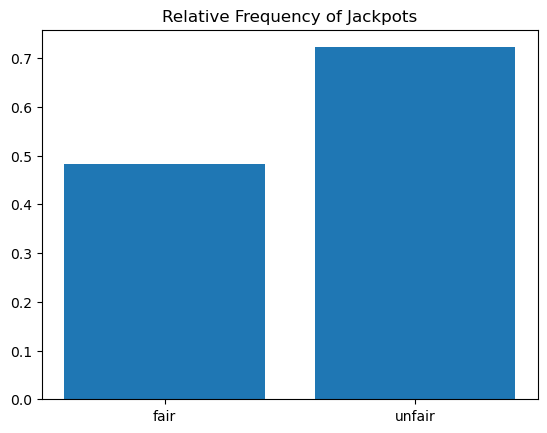

In [9]:
import matplotlib.pyplot as plt

plt.bar(['fair', 'unfair'],[fair_rel_freq, unfair_rel_freq])
plt.title('Relative Frequency of Jackpots');

## Scenario 2: A 6-sided Die (9)

Task 1. Create three dice, each with six sides having the faces 1 through 6.

- Three die objects created (1).

In [10]:
die1 = Die(np.array(['1','2','3','4','5','6']))
die2 = Die(np.array(['1','2','3','4','5','6']))
die3 = Die(np.array(['1','2','3','4','5','6']))

Task 2. Convert one of the dice to an unfair one by weighting the face $6$ five times more than the other weights (i.e. it has weight of 5 and the others a weight of 1 each).

- Unfair die created with proper call to weight change method (1).

In [11]:
die1.change_weight('6', 5)

Task 3. Convert another of the dice to be unfair by weighting the face $1$ five times more than the others.

- Unfair die created with proper call to weight change method (1).

In [12]:
die2.change_weight('1', 5)

Task 4. Play a game of $10000$ rolls with $5$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [13]:
fair_game2 = Game([die3, die3, die3, die3, die3, die3])
fair_game2.play_game(10000)
fair_game2.game_results()

,Die 1,Die 2,Die 3,Die 4,Die 5,Die 6
Roll 1,3,1,5,4,2,3
Roll 2,5,3,6,6,5,1
Roll 3,5,6,5,4,2,2
Roll 4,4,1,4,2,3,1
Roll 5,6,2,1,2,3,2
...,...,...,...,...,...,...
Roll 9996,6,3,5,4,6,1
Roll 9997,2,1,5,3,6,1
Roll 9998,3,2,2,1,2,5
Roll 9999,3,5,3,4,5,3


Task 5. Play another game of $10000$ rolls, this time with $2$ unfair dice, one as defined in steps #2 and #3 respectively, and $3$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [14]:
unfair_game2 = Game([die1, die2, die3, die3, die3])
unfair_game2.play_game(10000)
unfair_game2.game_results()

,Die 1,Die 2,Die 3,Die 4,Die 5
Roll 1,5,1,4,3,6
Roll 2,1,1,6,2,6
Roll 3,6,5,6,3,2
Roll 4,6,1,1,1,4
Roll 5,6,1,3,5,4
...,...,...,...,...,...
Roll 9996,6,1,2,2,1
Roll 9997,3,4,2,2,2
Roll 9998,6,1,4,6,1
Roll 9999,3,1,4,6,4


Task 6. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

- Jackpot methods called (1).
- Graph produced (1).

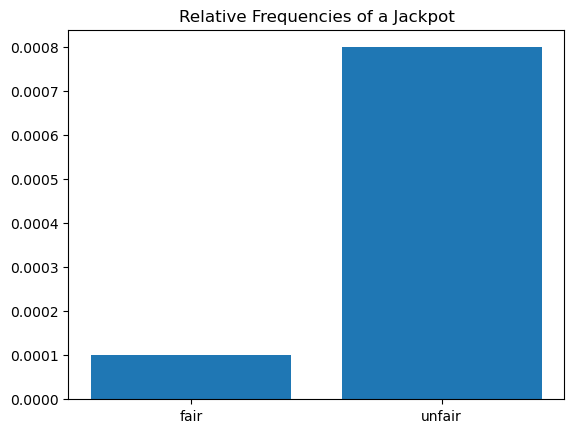

In [15]:
fair_analyzer2 = Analyzer(fair_game2)
unfair_analyzer2 = Analyzer(unfair_game2)

fair_rel_freq2 = fair_analyzer2.jackpot()/10000
unfair_rel_freq2 = unfair_analyzer2.jackpot()/10000

plt.bar(['fair','unfair'],[fair_rel_freq2, unfair_rel_freq2])
plt.title('Relative Frequencies of a Jackpot');

## Scenario 3: Letters of the Alphabet (7)

Task 1. Create a "die" of letters from $A$ to $Z$ with weights based on their frequency of usage as found in the data file `english_letters.txt`. Use the frequencies (i.e. raw counts) as weights.

- Die correctly instantiated with source file data (1).
- Weights properly applied using weight setting method (1).

In [36]:
english_letters = pd.read_csv('english_letters.txt', header=None, sep=' ')
letter_die = Die(np.array([i for i in english_letters[0]]))

english_letters = english_letters.set_index([english_letters[0]])
english_letters.columns = ['letter','weight']

for i in letter_die.faces:
    letter_die.change_weight(i, english_letters.weight[i])

Task 2. Play a game involving $4$ of these dice with $1000$ rolls.

- Game play method properly called (1).

In [37]:
letter_game = Game([letter_die, letter_die, letter_die, letter_die])
letter_game.play_game(1000)

Task 3. Determine how many permutations in your results are actual English words, based on the vocabulary found in `scrabble_words.txt`.

- Use permutation method (1).
- Get count as difference between permutations and vocabulary (1).

In [114]:
letter_analyzer = Analyzer(letter_game)
results_df = letter_analyzer.perm_count()
results_df['word'] = results_df.index.map(''.join)

In [115]:
scrabble = pd.read_csv('scrabble_words.txt', header=None)

results_set = set(results_df.word)
scrabble_set = set(scrabble.iloc[:,0])

len(results_set.intersection(scrabble_set))

44

Task 4. Repeat steps #2 and #3, this time with $5$ dice. How many actual words does this produce? Which produces more?

- Successfully repreats steps (1).
- Identifies parameter with most found words (1).

In [122]:
letter_game = Game([letter_die for i in range(5)])
letter_game.play_game(1000)

In [123]:
letter_analyzer = Analyzer(letter_game)
results_df = letter_analyzer.perm_count()
results_df['word'] = results_df.index.map(''.join)

In [124]:
results_set = set(results_df.word)
scrabble_set = set(scrabble.iloc[:,0])

len(results_set.intersection(scrabble_set))

9

The game with 4 die produces more words than the game with 5 die.